# BETO model

In [1]:
import pandas as pd

## General

### Senators_data

In [2]:
#Import senator csv from senator_data_file
senators = pd.read_csv(r'/Users/mimihuerta/code/jomilu93/sivico/data/senators_data.csv', converters={'initiative_list': pd.eval}, index_col='Unnamed: 0')
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,url_sitio,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,NaN,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,NaN,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...


In [4]:
#Dataset column names
columnas = senators.columns
columnas

Index(['senator_id', 'Apellidos', 'Nombre', 'Fraccion', 'Legislatura',
       'Estado', 'Sexo', 'tipoEleccion', 'Suplente', 'estadoOrigen', 'correo',
       'facebook', 'twitter', 'youtube', 'instagram', 'url_sitio', 'telefono',
       'extension', 'estatus', 'direccion', 'id', 'senadores',
       'attendance_score', 'initiative_list', 'initiatives_summary_dummy'],
      dtype='object')

<Axes: >

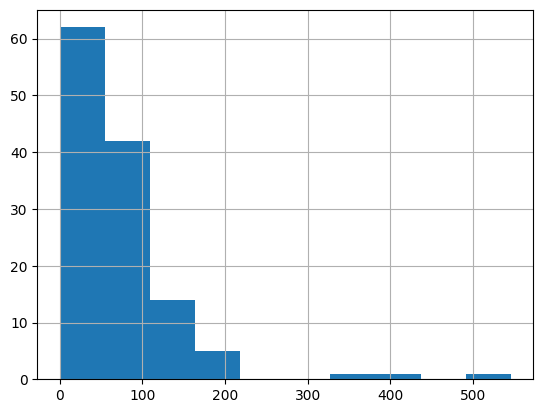

In [5]:
#Number of sentences in the dataset
len_col = [len(prop) for prop in senators["initiative_list"]]
pd.Series(len_col).hist()

<Axes: >

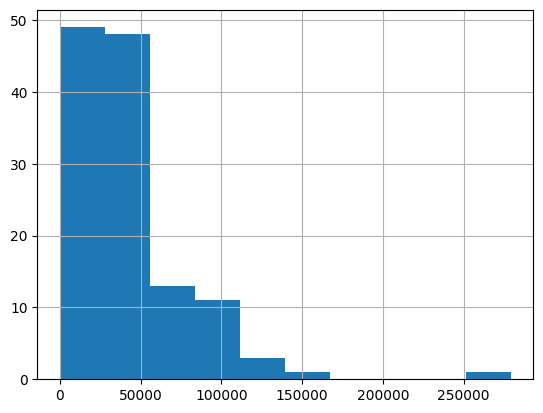

In [6]:
#Number of words in the dataset
len_col = [len(str(prop)) for prop in senators['initiatives_summary_dummy']]
               
pd.Series(len_col).hist()

In [7]:
#Exploring 'initiative_list'  
ex_i = len(senators['initiative_list'][1])
ex_i

39

In [9]:
##Exploring 'initiatives_summary_dummy' 
ex_s = senators['initiatives_summary_dummy'][1]
len(ex_s)

14197

## Model

In [10]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [11]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

The following encoder weights were not tied to the decoder ['bert/pooler']
Some weights of EncoderDecoderModel were not initialized from the model checkpoint at mrm8488/bert2bert_shared-spanish-finetuned-summarization and are newly initialized: ['decoder.bert.encoder.layer.2.attention.self.key.weight', 'decoder.bert.encoder.layer.7.attention.output.LayerNorm.weight', 'decoder.bert.encoder.layer.3.intermediate.dense.bias', 'decoder.bert.encoder.layer.4.attention.self.query.weight', 'decoder.bert.encoder.layer.7.attention.self.query.bias', 'decoder.bert.encoder.layer.11.output.LayerNorm.weight', 'decoder.bert.encoder.layer.6.attention.self.query.weight', 'decoder.bert.encoder.layer.7.attention.output.dense.weight', 'decoder.bert.encoder.layer.3.attention.self.key.weight', 'decoder.bert.encoder.layer.10.attention.self.query.weight', 'decoder.bert.encoder.layer.5.output.dense.bias', 'decoder.bert.encoder.layer.5.attention.output.LayerNorm.weight', 'decoder.bert.encoder.layer.0.output.Layer

The following encoder weights were not tied to the decoder ['bert/pooler']


### Option 1 -- 'initiatives_summary_dummy'

In [ ]:
inputs = tokenizer.encode("RESUMEN: " + ex_s, return_tensors="pt", max_length=511, truncation=True)
len(inputs[0])

In [ ]:
resumen = model.generate(
    inputs, 
    max_length=10000,
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen[0]))

In [ ]:
prop_inc_t = senators['initiatives_summary_dummy_split']
prop_inc_t[0]

In [ ]:
#Split the concatenated initiatives for each senator into bites smaller than 511 to be able to consider inside the model.
senators["initiatives_summary_dummy_split"] = ""

n = 511

for i, row in senators.iterrows():
    if not row["initiative_list"] == []:
        initiatives_split = [row["initiatives_summary_dummy"][i:i+n] for i in range(0, len(row["initiatives_summary_dummy"]), n)]
        senators.at[i, "initiatives_summary_dummy_split"] = initiatives_split
    else:
        senators.at[i, "initiatives_summary_dummy_split"] = []

In [ ]:
senators.head(2)

In [ ]:
len(senators['initiatives_summary_dummy_split'][0]

In [ ]:
senators['initiatives_summary_dummy_split'][0]

In [ ]:
def summarizeRow(prop_inc_t, resumentList, inputsList):
    for parag in prop_inc_t:
        inputs = tokenizer.encode(parag, return_tensors="pt", max_length=511, truncation=True)
        inputsList.append(inputs)
        resumen = model.generate(
            inputs, 
            max_length=200,
            min_length=5, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True)
        resumentList.append(tokenizer.decode(resumen[0]))

resumentList = []
inputsList = []

summarizeRow(prop_inc_t[0], resumentList, inputsList)

In [ ]:
for row in prop_inc_t[:5]:
    resumentList = []
    inputsList = []

    summarizeRow(row, resumentList, inputsList)
    
    print(inputsList)
    print(resumentList)

### Option 2 -- 'initiative_list'

In [12]:
#Example
senators['initiative_list'][0]

['Pretende garantizar a los miembros del Servicio Exterior Mexicano, en un porcentaje mayor al que se establece en la legislación actual, el acceso a los cargos de representación del estado como Embajador o Cónsul.',
 'Propone establecer una mayor claridad en la subdivisión de las comisiones ordinarias de Educación, Cultura y Ciencia y Tecnología, suprimiendo la única denominación vigente de la comisión ordinaria de “Educación, Cultura, Ciencia y Tecnología”.',
 'Propone establecer que el instituto de Servicios Periciales y Ciencias Forenses será el área técnica de apoyo a la Fiscalía que tendrá como objetivo fortalecer su capacidad institucional para realizar sus funciones de manera especializada y científica. Determina el establecimiento de un Servicio de Carrera Pericial.',
 'Propone establecer que las iniciativas ciudadanas tengan el carácter de preferente.',
 'Propone establecer que el Sistema Educativo Nacional considerará la educación en materia de privacidad y protección de sus

In [13]:
#Function that performs the summary by row
def summarizeRow(prop_inc_t, resumentList, inputsList):
    for parag in prop_inc_t:
        inputs = tokenizer.encode(parag, return_tensors="pt", max_length=511, truncation=True)
        inputsList.append(inputs)
        resumen = model.generate(
            inputs, 
            max_length=200,
            min_length=5, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True)
        resumentList.append(tokenizer.decode(resumen[0]))

In [14]:
resumentList_2 = []
inputsList_2 = []

summarizeRow(senators['initiative_list'][0], resumentList_2, inputsList_2)

2023-07-13 22:33:10.029146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#Adding BETO to dataset
senators['BETO_summary'] = ""
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy,BETO_summary
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...,
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...,


In [17]:
#For the entire dataset ... (only a few in the following example) ... change this value
index = 0
for row in senators['initiative_list'][:2]:
    resumentList_2 = []
    inputsList_2 = []

    summarizeRow(row, resumentList_2, inputsList_2)
    senators['BETO_summary'][index] = resumentList_2
    index += 1
    #print(inputsList_2)
    print(resumentList_2)

senators.head(2)

/var/folders/n7/388dqz5d5fd0c4nd5dh86cbh0000gp/T/ipykernel_38145/3988919780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senators['BETO_summary'][index] = resumentList_2


['[CLS] Pretende garantizar a los miembros del Servicio Exterior Mexicano, en un porcentaje mayor al que se establece en la legislación actual [SEP]', '[CLS] Propone establecer una mayor claridad en la subdivisión de las comisiones ordinarias de Educación, Cultura y Tecnología [SEP]', '[CLS] Propone establecer que el instituto de Servicios Periciales y Ciencias Forenses será el área técnica de apoyo a la Fiscalía que tendrá como objetivo fortalecer su capacidad institucional para realizar sus funciones de manera especializada y científica [SEP]', '[CLS] Propone establecer que las iniciativas ciudadanas tengan el carácter de preferente [SEP]', '[CLS] Propone establecer que el sistema educativo Nacional considere la educación en materia de privacidad y protección de sus datos personales en el ámbito digital [SEP]', '[CLS] Propone expedir un nuevo ordenamiento para establecer las bases para la protección de las mujeres en situación de calle, víctimas de violencia o violencia sexual [SEP]'

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy,BETO_summary
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...,[[CLS] Pretende garantizar a los miembros del ...
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...,[[CLS] Propone que el Estado apoye la investig...


In [18]:
(senators["BETO_summary"][1])

['[CLS] Propone que el Estado apoye la investigación e innovación científica humanística y tecnológica [SEP]',
 '[CLS] Propone aumentar el porcentaje con el que se constituye el Fondo de Salud para el Bienestar del 11 % al 13 % [SEP]',
 '[CLS] Propone la creación de un Fondo en materia de Seguridad Pública para municipios y demarcaciones territoriales de la Ciudad de México [SEP]',
 '[CLS] Propone que no sea excepción para el ejercicio de los derechos de los familiares derechohabientes el que estos tengan por si mismo derechos propios a seguros, prestaciones y servicios que prevé la seguridad social [SEP]',
 '[CLS] Propone suprimir del texto constitucional la disposición vigente que establece la figura del arraigo [SEP]',
 '[CLS] La Corte de Justicia de la Nación establece que las declaraciones de invalidez podrán ser presentadas por el equivalente al 25 % de los miembros de alguna de las Cámaras del Congreso de la Unión [SEP]',
 '[CLS] Propone eliminar la disposición normativa que est

https://albertauyeung.github.io/2020/06/19/bert-tokenization.html/

### Option 3 -- deprecated

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [ ]:
inputs_2 = tokenizer.encode("RESUMEN: " + a, return_tensors="pt", max_length=1000, truncation=True)
inputs_2

In [ ]:
resumen_2 = model.generate(
    inputs, 
    max_length=500, 
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen_2[0]))

### Notes

In [ ]:
tokenizer.model_max_lenght
model.config.max_position_embeddings()
embeddings = TransformerWordEmbeddings(
    "path/to/model",
    layers="-1",
    subtoken_pooling="first",
    fine_tune=True,
    use_context=True,
    allow_long_sentences=True,
    model_max_length=512  # pass length